# Manhattan Taxi Trip Analysis - March 8, 2013

This notebook processes NYC taxi trip data for Manhattan zip codes on March 8, 2013, focusing on hours 19-21 (7pm-9pm).

## Pipeline Overview:
1. **Data Loading & Zone Assignment** - Load trip data and assign Manhattan zip codes via spatial join
2. **Fare Integration** - Merge trip and fare data
3. **Trip Filtering & Aggregation** - Remove same-zone trips and group by time_stamp and route
4. **Fleet Sizing** - Calculate realistic fleet size based on actual vehicle activity (scaled for same-zone removal)
5. **Scenario Generation** - Create JSON for simulation with topology graph based on geographic adjacency
6. **Peak Hour Analysis** - Detailed analysis of 7pm-8pm trip patterns and geographic flows


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import itertools
import time
from shapely.geometry import Point
import json

# Global constants - Manhattan zip codes
MANHATTAN_ZIP_CODES = ['10002', '10003', '10005', '10006', '10007', '10009', 
                       '10010', '10011', '10012', '10013', '10014', '10038']

# Helper function for spatial join with duplicate handling
def assign_zip_codes(points, zones):
    """Assign zip codes to points via spatial join, handling duplicates."""
    gdf = gpd.GeoDataFrame(
        pd.Series(range(len(points)), name='original_index'),
        geometry=points,
        crs="EPSG:4326"
    )
    gdf = gpd.sjoin(gdf, zones[['geometry', 'postalCode']], how="left", predicate="intersects")
    gdf = gdf.drop_duplicates(subset=['original_index'], keep='first').sort_values('original_index')
    return gdf['postalCode'].values

print(f"Target: March 8th, 2013, Hours 19-21")
print(f"Manhattan zip codes: {MANHATTAN_ZIP_CODES}")


Target: March 8th, 2013, Hours 19-21
Manhattan zip codes: ['10002', '10003', '10005', '10006', '10007', '10009', '10010', '10011', '10012', '10013', '10014', '10038']


In [13]:
trip_data_df = pd.read_csv("Trip Data/trip_data_3.csv")
trip_data_df.columns = trip_data_df.columns.str.strip()
trip_data_df['pickup_datetime'] = pd.to_datetime(trip_data_df['pickup_datetime'])

# Filter for March 8th
trip_data_df = trip_data_df[(trip_data_df['pickup_datetime'].dt.month == 3) & 
                            (trip_data_df['pickup_datetime'].dt.day == 8)]

trip_data_df = trip_data_df.dropna(subset=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])

# Load NYC zip code geometries and filter for Manhattan
nyc_zones = gpd.read_file("nyc-zip-code-tabulation-areas-polygons.geojson").to_crs(epsg=4326)
mh_zones = nyc_zones[nyc_zones['postalCode'].isin(MANHATTAN_ZIP_CODES)]

# Create point geometries
trip_data_df = trip_data_df.reset_index(drop=True)
pickup_points = gpd.points_from_xy(trip_data_df['pickup_longitude'], trip_data_df['pickup_latitude'])
dropoff_points = gpd.points_from_xy(trip_data_df['dropoff_longitude'], trip_data_df['dropoff_latitude'])

# Assign zip codes using helper function
trip_data_df['pickup_zone'] = assign_zip_codes(pickup_points, mh_zones)
trip_data_df['dropoff_zone'] = assign_zip_codes(dropoff_points, mh_zones)

# Filter for Manhattan-to-Manhattan trips
trip_data_df = trip_data_df[
    trip_data_df['pickup_zone'].isin(MANHATTAN_ZIP_CODES) &
    trip_data_df['dropoff_zone'].isin(MANHATTAN_ZIP_CODES)
]

trip_data_df['trip_id'] = (
    trip_data_df['medallion'].astype(str) + "_" +
    trip_data_df['hack_license'].astype(str) + "_" +
    trip_data_df['pickup_datetime'].astype(str)
)

trip_data_df['time_stamp'] = (trip_data_df['pickup_datetime'].dt.hour * 60 + 
                              trip_data_df['pickup_datetime'].dt.minute + 
                              (trip_data_df['pickup_datetime'].dt.second >= 30).astype(int))

trip_data_df.to_csv("trip_data_with_mh_zones.csv", index=False)


## 2. Merge Fare Data with Trip Data

In [14]:
trip_fare_df = pd.read_csv("Trip Data/trip_fare_3.csv")
trip_fare_df.columns = trip_fare_df.columns.str.strip()
trip_fare_df['pickup_datetime'] = pd.to_datetime(trip_fare_df['pickup_datetime'])

# Filter for March 8th
trip_fare_df = trip_fare_df[
    (trip_fare_df['pickup_datetime'].dt.month == 3) & 
    (trip_fare_df['pickup_datetime'].dt.day == 8)
].copy()

trip_fare_df['trip_id'] = (
    trip_fare_df['medallion'].astype(str) + "_" +
    trip_fare_df['hack_license'].astype(str) + "_" +
    trip_fare_df['pickup_datetime'].astype(str)
)

trip_fare_df['price'] = (
    trip_fare_df['fare_amount'] + trip_fare_df['surcharge'] + 
    trip_fare_df['mta_tax'] + trip_fare_df['tip_amount'] + trip_fare_df['tolls_amount']
)

trips = trip_fare_df[['trip_id', 'price']].merge(trip_data_df, on='trip_id', how='inner')
trips.to_csv("trips_with_mh_zones_and_fares.csv", index=False)


## 3. Aggregate Trips for Hours 19-21

In [16]:
trips['trip_time_in_mins'] = trips['trip_time_in_secs'] / 60
trips['pickup_datetime'] = pd.to_datetime(trips['pickup_datetime'])
trips['hour'] = trips['pickup_datetime'].dt.hour

# trips between 19:00 and 21:00
trips_filtered = trips[(trips['hour'] >= 19) & (trips['hour'] <= 21)].copy()

# Remove trips where pickup and dropoff zones are the same
trips_before_filtering = len(trips_filtered)
trips_filtered = trips_filtered[trips_filtered['pickup_zone'] != trips_filtered['dropoff_zone']].copy()
trips_after_filtering = len(trips_filtered)
trips_removed = trips_before_filtering - trips_after_filtering
removal_percentage = (trips_removed / trips_before_filtering) * 100
reduction_factor = trips_after_filtering / trips_before_filtering

print(f"Same-zone trip removal statistics:")
print(f"  Trips before filtering: {trips_before_filtering:,}")
print(f"  Same-zone trips removed: {trips_removed:,}")
print(f"  Trips after filtering: {trips_after_filtering:,}")
print(f"  Percentage removed: {removal_percentage:.2f}%")
print(f"  Reduction factor: {reduction_factor:.4f}")
print(f"  Remaining trips: {(1-reduction_factor)*100:.2f}% reduction needed in vehicles\n")

aggregated_trips = trips_filtered.groupby(['time_stamp', 'pickup_zone', 'dropoff_zone']).agg(
    demand=('trip_id', 'count'), 
    travel_time=('trip_time_in_mins', 'mean'), 
    price=('price', 'mean')  
).reset_index()

statistics = aggregated_trips['price'].describe()
print(statistics)

# Create a mapping from zip codes to 0-indexed zones
zip_to_zone = {zip_code: idx for idx, zip_code in enumerate(MANHATTAN_ZIP_CODES)}

aggregated_trips['time_stamp'] = aggregated_trips['time_stamp'].astype(int)
aggregated_trips['origin'] = aggregated_trips['pickup_zone'].map(zip_to_zone)
aggregated_trips['destination'] = aggregated_trips['dropoff_zone'].map(zip_to_zone)
aggregated_trips['demand'] = aggregated_trips['demand'].astype(int)
aggregated_trips['travel_time'] = aggregated_trips['travel_time'].astype(int)
aggregated_trips['price'] = aggregated_trips['price'].round(2)

aggregated_trips = aggregated_trips.drop(columns=['pickup_zone', 'dropoff_zone'])

aggregated_trips.to_csv("aggregated_trips_filtered.csv", index=False)


Same-zone trip removal statistics:
  Trips before filtering: 18,147
  Same-zone trips removed: 2,525
  Trips after filtering: 15,622
  Percentage removed: 13.91%
  Reduction factor: 0.8609
  Remaining trips: 13.91% reduction needed in vehicles

count    8646.000000
mean       10.269503
std         3.025608
min         4.500000
25%         8.250000
50%         9.750000
75%        11.750000
max        65.500000
Name: price, dtype: float64


## 4. Determine Available Vehicles for Simulation

Before generating the scenario, we analyze the actual number of unique vehicles (medallions) operating during the 7pm-8pm peak hour to set realistic fleet sizes.

In [28]:
# Analyze unique vehicles during 7pm-8pm (hour 19) for realistic fleet sizing
trips_7pm_8pm = trips[trips['hour'] == 19].copy()

# Remove same-zone trips to match the filtering applied to aggregated trips
trips_7pm_8pm_before = len(trips_7pm_8pm)
trips_7pm_8pm = trips_7pm_8pm[trips_7pm_8pm['pickup_zone'] != trips_7pm_8pm['dropoff_zone']].copy()
trips_7pm_8pm_after = len(trips_7pm_8pm)

trips_7pm_8pm['medallion'] = trips_7pm_8pm['trip_id'].str.split('_').str[0]
trips_7pm_8pm['hack_license'] = trips_7pm_8pm['trip_id'].str.split('_').str[1]

unique_medallions_7pm_8pm = trips_7pm_8pm['medallion'].nunique()
unique_drivers_7pm_8pm = trips_7pm_8pm['hack_license'].nunique()

# Calculate the reduction factor from removing same-zone trips
reduction_factor_7pm = trips_7pm_8pm_after / trips_7pm_8pm_before

# Scale down the number of vehicles by the same percentage
scaled_vehicles = int(unique_medallions_7pm_8pm * reduction_factor_7pm)

print("=" * 70)
print("VEHICLE & DRIVER AVAILABILITY ANALYSIS (7pm-8pm, Hour 19)")
print("=" * 70)
print(f"Same-zone trips removed: {trips_7pm_8pm_before - trips_7pm_8pm_after:,} ({(1-reduction_factor_7pm)*100:.2f}%)")
print(f"Remaining trips: {trips_7pm_8pm_after:,}")
print(f"\nOriginal Fleet (before scaling):")
print(f"   Unique Cars (Medallions):      {unique_medallions_7pm_8pm:,}")
print(f"   Unique Drivers (Hack License): {unique_drivers_7pm_8pm:,}")
print(f"\nScaled Fleet (after same-zone removal):")
print(f"   Scaled vehicles: {scaled_vehicles:,}")
print(f"   Reduction factor: {reduction_factor_7pm:.4f}")
print(f"\nTrip Statistics (using scaled fleet):")
print(f"   Total trips in hour: {len(trips_7pm_8pm):,}")
print(f"   Average trips per car: {len(trips_7pm_8pm)/scaled_vehicles:.2f}")
print(f"   Average trips per driver: {len(trips_7pm_8pm)/unique_drivers_7pm_8pm:.2f}")
print("=" * 70)


VEHICLE & DRIVER AVAILABILITY ANALYSIS (7pm-8pm, Hour 19)
Same-zone trips removed: 838 (13.87%)
Remaining trips: 5,205

Original Fleet (before scaling):
   Unique Cars (Medallions):      3,385
   Unique Drivers (Hack License): 3,385

Scaled Fleet (after same-zone removal):
   Scaled vehicles: 2,915
   Reduction factor: 0.8613

Trip Statistics (using scaled fleet):
   Total trips in hour: 5,205
   Average trips per car: 1.79
   Average trips per driver: 1.54


## 5. Generate Scenario JSON for Simulation

In [30]:
demand_list = aggregated_trips.to_dict(orient='records')

# Use scaled vehicle count from 7pm-8pm analysis (after removing same-zone trips)
total_acc = [
    {"hour": 19, "acc": scaled_vehicles},
    {"hour": 20, "acc": scaled_vehicles},
    {"hour": 21, "acc": scaled_vehicles}
]

# Load rebalancing times (now using zip codes)
reb_time = pd.read_csv("south_manhattan_reb_times.csv")

# Debug: Check the loaded data
print("=" * 70)
print("DEBUG: Checking rebalancing times CSV")
print("=" * 70)
print(f"Columns in CSV: {list(reb_time.columns)}")
print(f"Number of rows: {len(reb_time)}")
print(f"\nFirst 5 rows:")
print(reb_time.head())
print(f"\nData types:")
print(reb_time.dtypes)
print(f"\nUnique pickup zones: {reb_time['pickup_zone'].unique()[:10]}")
print(f"Unique dropoff zones: {reb_time['dropoff_zone'].unique()[:10]}")
print("=" * 70)

# Create mapping from zip codes to 0-indexed zones
zip_to_zone = {zip_code: idx for idx, zip_code in enumerate(MANHATTAN_ZIP_CODES)}
print(f"\nZip to zone mapping: {zip_to_zone}")

# Convert integer zip codes to strings before mapping (CSV has int64, but mapping expects strings)
reb_time['pickup_zone'] = reb_time['pickup_zone'].astype(str)
reb_time['dropoff_zone'] = reb_time['dropoff_zone'].astype(str)

# Map pickup_zone and dropoff_zone to 0-indexed origin and destination
reb_time['origin'] = reb_time['pickup_zone'].map(zip_to_zone)
reb_time['destination'] = reb_time['dropoff_zone'].map(zip_to_zone)

# Check for NaN values after mapping
nan_origins = reb_time['origin'].isna().sum()
nan_destinations = reb_time['destination'].isna().sum()
print(f"\nNaN values after mapping:")
print(f"  Origins: {nan_origins} ({nan_origins/len(reb_time)*100:.1f}%)")
print(f"  Destinations: {nan_destinations} ({nan_destinations/len(reb_time)*100:.1f}%)")

if nan_origins > 0 or nan_destinations > 0:
    print(f"\n⚠️ WARNING: Found NaN values in origin/destination mapping!")
    print("Sample rows with NaN:")
    print(reb_time[reb_time['origin'].isna() | reb_time['destination'].isna()].head())
    
reb_time = reb_time.rename(columns={'reb_time': 'reb_time_value'})
reb_time['reb_time_value'] = reb_time['reb_time_value'].round(2)

# Keep only needed columns
reb_time = reb_time[['time_stamp', 'origin', 'destination', 'reb_time_value']].copy()
reb_time = reb_time.rename(columns={'reb_time_value': 'reb_time'})

reb_time_list = reb_time.to_dict(orient='records')

# Topology graph based on actual geographic adjacency of Manhattan zip codes
# Zone indices: 0=10002, 1=10003, 2=10005, 3=10006, 4=10007, 5=10009, 
#               6=10010, 7=10011, 8=10012, 9=10013, 10=10014, 11=10038
topology_graph_dict = {
    0: [1, 5, 8, 9, 11],              # 10002: Lower East Side ->
    1: [0, 5, 6, 7, 8],     # 10003: East Village -> 
    2: [3, 11],          # 10005: Financial District ->
    3: [2, 4, 11],          # 10006: Financial District ->
    4: [3, 9, 11],       # 10007: Tribeca/Civic Center -> 
    5: [0, 1, 6],           # 10009: East Village/Alphabet City -> 
    6: [1, 5, 7],           # 10010: Gramercy/Flatiron -> 
    7: [1, 6, 8, 10],       # 10011: Chelsea/West Village ->
    8: [0, 1, 7, 9, 10],       # 10012: SoHo/Nolita -> 
    9: [0, 4, 8, 10, 11],      # 10013: Tribeca/Chinatown -> 
    10: [7, 8, 9],          # 10014: West Village/Meatpacking ->
    11: [0, 2, 3, 4, 9]        # 10038: Financial District/Battery Park ->
}

topology_graph_json = [
    {"i": zone, "j": neighbor}
    for zone, neighbors in topology_graph_dict.items()
    for neighbor in neighbors
]

scenario_data = {
    "nlat" : 12,
    "nlon" : 1,
    "demand" : demand_list,
    "totalAcc": total_acc,
    "rebTime": reb_time_list,
    "topology_graph": topology_graph_json
}

output_json_file = "scenario_nyc_south_manhattan.json"
with open(output_json_file, "w") as json_file:
    json.dump(scenario_data, json_file, indent=2)

print(f"\n✓ JSON file saved as {output_json_file}")
print(f"✓ Fleet size set to: {scaled_vehicles} vehicles per hour")
print(f"\nZip code to zone index mapping:")
for zip_code, idx in zip_to_zone.items():
    neighbors_zips = [MANHATTAN_ZIP_CODES[n] for n in topology_graph_dict[idx]]
    print(f"  Zone {idx} ({zip_code}): adjacent to {neighbors_zips}")


DEBUG: Checking rebalancing times CSV
Columns in CSV: ['time_stamp', 'pickup_zone', 'dropoff_zone', 'reb_time']
Number of rows: 1728

First 5 rows:
   time_stamp  pickup_zone  dropoff_zone   reb_time
0          12        10002         10002   0.000000
1          12        10002         10003   7.341270
2          12        10002         10005  10.005673
3          12        10002         10006  14.370417
4          12        10002         10007  12.263954

Data types:
time_stamp        int64
pickup_zone       int64
dropoff_zone      int64
reb_time        float64
dtype: object

Unique pickup zones: [10002 10003 10005 10006 10007 10009 10010 10011 10012 10013]
Unique dropoff zones: [10002 10003 10005 10006 10007 10009 10010 10011 10012 10013]

Zip to zone mapping: {'10002': 0, '10003': 1, '10005': 2, '10006': 3, '10007': 4, '10009': 5, '10010': 6, '10011': 7, '10012': 8, '10013': 9, '10014': 10, '10038': 11}

NaN values after mapping:
  Origins: 0 (0.0%)
  Destinations: 0 (0.0%)

✓ JSON 

---
## 6. Peak Hour Analysis (7pm-8pm)

Detailed analysis of trip patterns, vehicle activity, and geographic flows during the busiest hour.

### 6.1 Summary Statistics

Note: Vehicle and driver analysis is in Section 4 above (scaled fleet size: `scaled_vehicles`).


In [23]:
# Filter aggregated trips for 7pm-8pm (hour 19)
trips_7pm_to_8pm = aggregated_trips[
    (aggregated_trips['time_stamp'] >= 19*60) & 
    (aggregated_trips['time_stamp'] < 20*60)
]

total_demand_7pm_8pm = trips_7pm_to_8pm['demand'].sum()
unique_routes_7pm_8pm = len(trips_7pm_to_8pm)

print("=" * 70)
print("TRIPS BETWEEN 7 PM (19:00) AND 8 PM (20:00) - DATA SUMMARY")
print("=" * 70)
print(f"\n📊 Trip Counts:")
print(f"   Total trips: {total_demand_7pm_8pm:,}")
print(f"   Unique route-time combinations: {unique_routes_7pm_8pm:,}")
print(f"   Average trips per route-time combo: {total_demand_7pm_8pm/unique_routes_7pm_8pm:.2f}")
print(f"\n📈 Time Range:")
print(f"   Minutes: {trips_7pm_to_8pm['time_stamp'].min()} to {trips_7pm_to_8pm['time_stamp'].max()}")
print(f"\n🚗 Fleet Info (from Section 4):")
print(f"   Active vehicles: {scaled_vehicles:,}")
print(f"   Average trips per vehicle: {total_demand_7pm_8pm/scaled_vehicles:.2f}")
print("=" * 70)

trips_7pm_to_8pm.head(10)


TRIPS BETWEEN 7 PM (19:00) AND 8 PM (20:00) - DATA SUMMARY

📊 Trip Counts:
   Total trips: 5,180
   Unique route-time combinations: 2,841
   Average trips per route-time combo: 1.82

📈 Time Range:
   Minutes: 1140 to 1199

🚗 Fleet Info (from Section 4):
   Active vehicles: 2,915
   Average trips per vehicle: 1.78


,time_stamp,demand,travel_time,price,origin,destination
0,1140,1,7,8.50,0,5
1,1140,1,10,12.85,1,0
2,1140,1,11,10.50,1,4
3,1140,3,6,9.30,1,5
4,1140,1,5,8.30,1,6
5,1140,4,12,12.08,1,7
6,1140,2,9,9.50,1,9
7,1140,1,24,18.00,1,10
8,1140,1,6,7.00,5,0
9,1140,2,6,7.25,5,1


### 6.2 Origin-Destination Flow Patterns


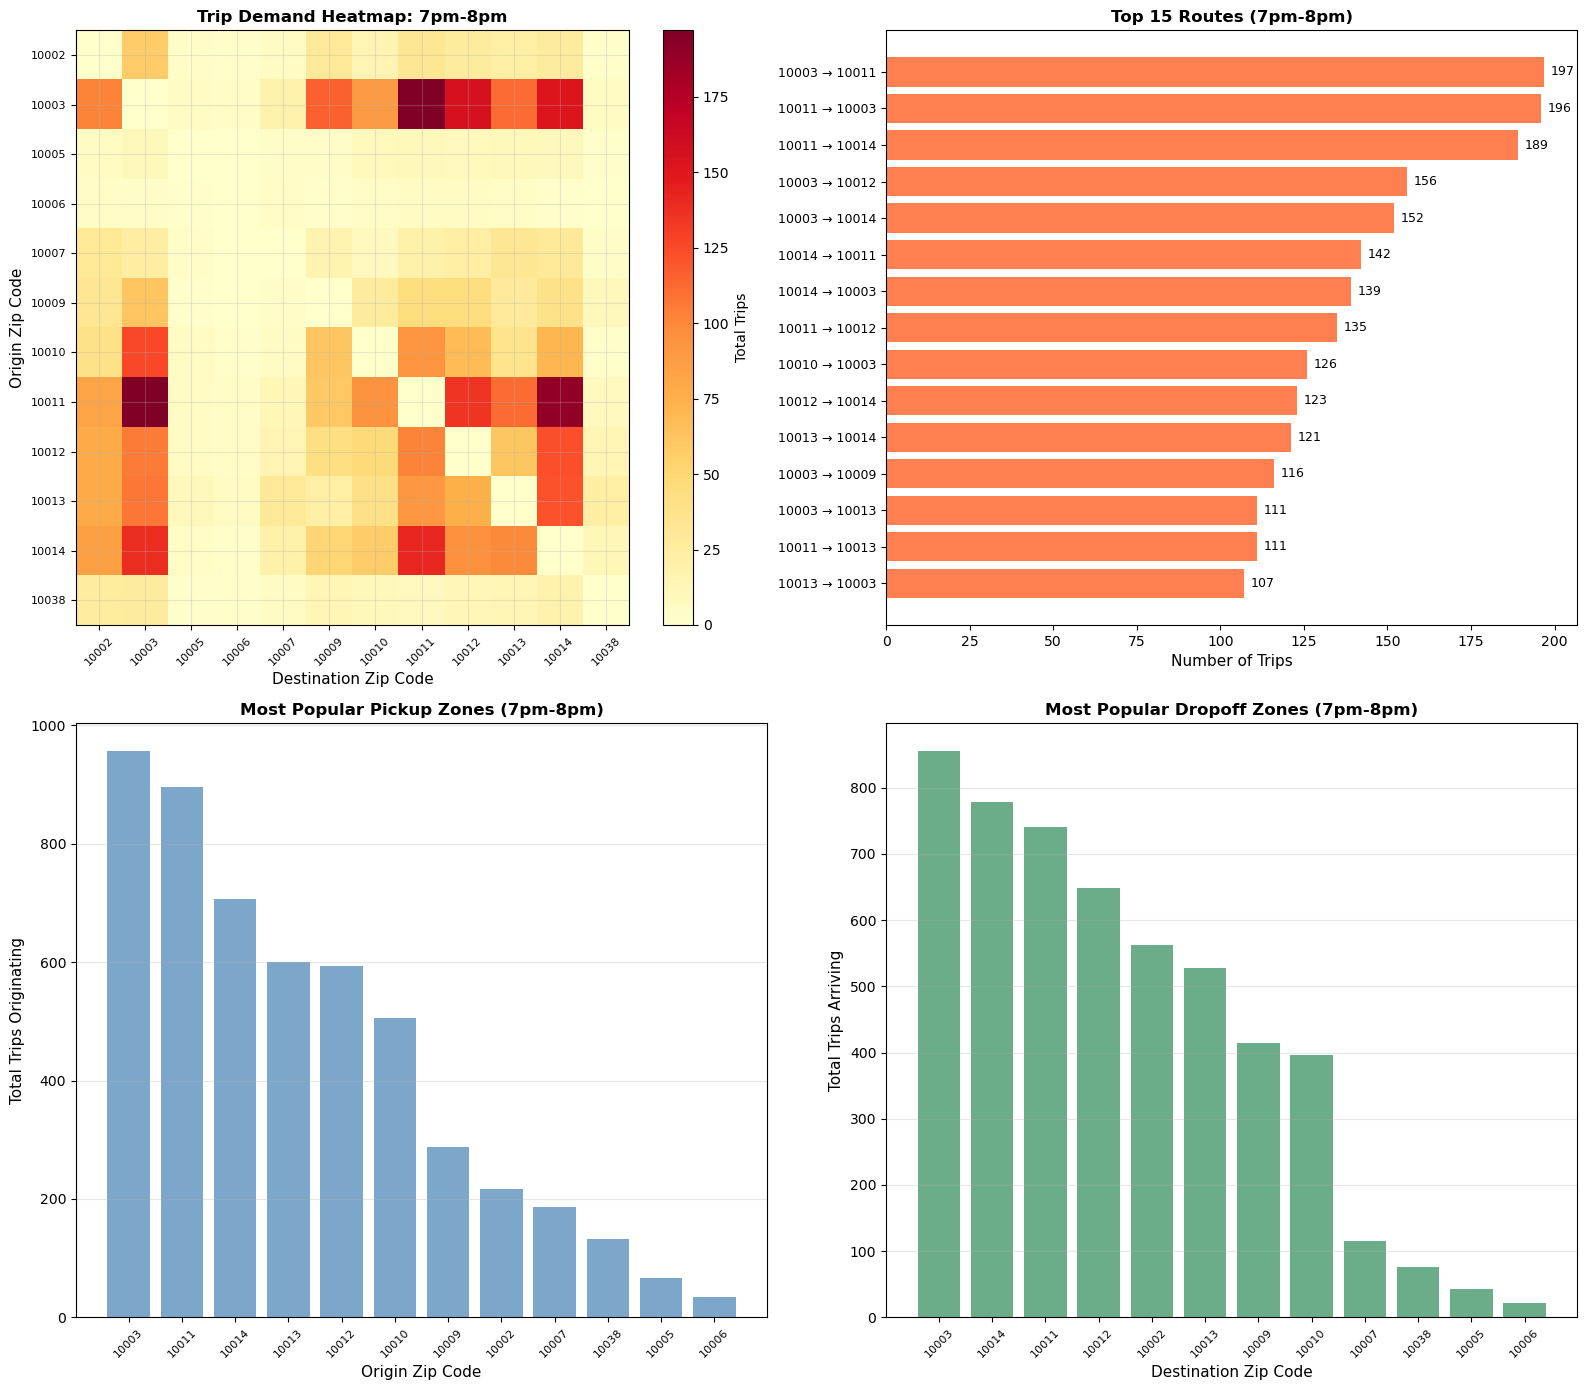


Total trips: 5,180
Busiest origin: 10003 with 956 trips
Busiest destination: 10003 with 855 trips
Busiest route: 10003 → 10011 with 197 trips


In [27]:
# Visualize trip patterns between 7pm-8pm
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Prepare data for heatmap - aggregate demand by origin and destination
heatmap_data = trips_7pm_to_8pm.groupby(['origin', 'destination'])['demand'].sum().reset_index()
heatmap_pivot = heatmap_data.pivot(index='origin', columns='destination', values='demand')
heatmap_pivot = heatmap_pivot.fillna(0)

# Map zone indices to zip codes for labels
zone_to_zip = {idx: zip_code for idx, zip_code in enumerate(MANHATTAN_ZIP_CODES)}
zip_labels = [zone_to_zip[i] for i in sorted(zone_to_zip.keys())]

# Heatmap of all trips
im1 = axes[0, 0].imshow(heatmap_pivot, cmap='YlOrRd', aspect='auto')
axes[0, 0].set_xlabel('Destination Zip Code', fontsize=11)
axes[0, 0].set_ylabel('Origin Zip Code', fontsize=11)
axes[0, 0].set_title('Trip Demand Heatmap: 7pm-8pm', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(range(len(heatmap_pivot.columns)))
axes[0, 0].set_xticklabels([zip_labels[i] for i in heatmap_pivot.columns], fontsize=8, rotation=45)
axes[0, 0].set_yticks(range(len(heatmap_pivot.index)))
axes[0, 0].set_yticklabels([zip_labels[i] for i in heatmap_pivot.index], fontsize=8)
plt.colorbar(im1, ax=axes[0, 0], label='Total Trips')
axes[0, 0].grid(True, alpha=0.3)

# Top 15 Origin-Destination pairs
top_15_routes = heatmap_data.nlargest(15, 'demand')
route_labels = [f"{zone_to_zip[row['origin']]} → {zone_to_zip[row['destination']]}" 
                for _, row in top_15_routes.iterrows()]
axes[0, 1].barh(range(len(top_15_routes)), top_15_routes['demand'].values, color='coral')
axes[0, 1].set_yticks(range(len(top_15_routes)))
axes[0, 1].set_yticklabels(route_labels, fontsize=9)
axes[0, 1].set_xlabel('Number of Trips', fontsize=11)
axes[0, 1].set_title('Top 15 Routes (7pm-8pm)', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
for i, (_, row) in enumerate(top_15_routes.iterrows()):
    axes[0, 1].text(row['demand'] + 2, i, f"{int(row['demand'])}", va='center', fontsize=9)

# Most popular origin zones
origin_totals = heatmap_data.groupby('origin')['demand'].sum().sort_values(ascending=False)
origin_zip_labels = [zone_to_zip[idx] for idx in origin_totals.index]
axes[1, 0].bar(range(len(origin_totals)), origin_totals.values, color='steelblue', alpha=0.7)
axes[1, 0].set_xticks(range(len(origin_totals)))
axes[1, 0].set_xticklabels(origin_zip_labels, fontsize=8, rotation=45)
axes[1, 0].set_xlabel('Origin Zip Code', fontsize=11)
axes[1, 0].set_ylabel('Total Trips Originating', fontsize=11)
axes[1, 0].set_title('Most Popular Pickup Zones (7pm-8pm)', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Most popular destination zones
dest_totals = heatmap_data.groupby('destination')['demand'].sum().sort_values(ascending=False)
dest_zip_labels = [zone_to_zip[idx] for idx in dest_totals.index]
axes[1, 1].bar(range(len(dest_totals)), dest_totals.values, color='seagreen', alpha=0.7)
axes[1, 1].set_xticks(range(len(dest_totals)))
axes[1, 1].set_xticklabels(dest_zip_labels, fontsize=8, rotation=45)
axes[1, 1].set_xlabel('Destination Zip Code', fontsize=11)
axes[1, 1].set_ylabel('Total Trips Arriving', fontsize=11)
axes[1, 1].set_title('Most Popular Dropoff Zones (7pm-8pm)', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal trips: {heatmap_data['demand'].sum():,}")
print(f"Busiest origin: {zone_to_zip[origin_totals.index[0]]} with {origin_totals.values[0]:,.0f} trips")
print(f"Busiest destination: {zone_to_zip[dest_totals.index[0]]} with {dest_totals.values[0]:,.0f} trips")
print(f"Busiest route: {zone_to_zip[top_15_routes.iloc[0]['origin']]} → {zone_to_zip[top_15_routes.iloc[0]['destination']]} with {top_15_routes.iloc[0]['demand']:.0f} trips")


### 6.3 Geographic Visualization


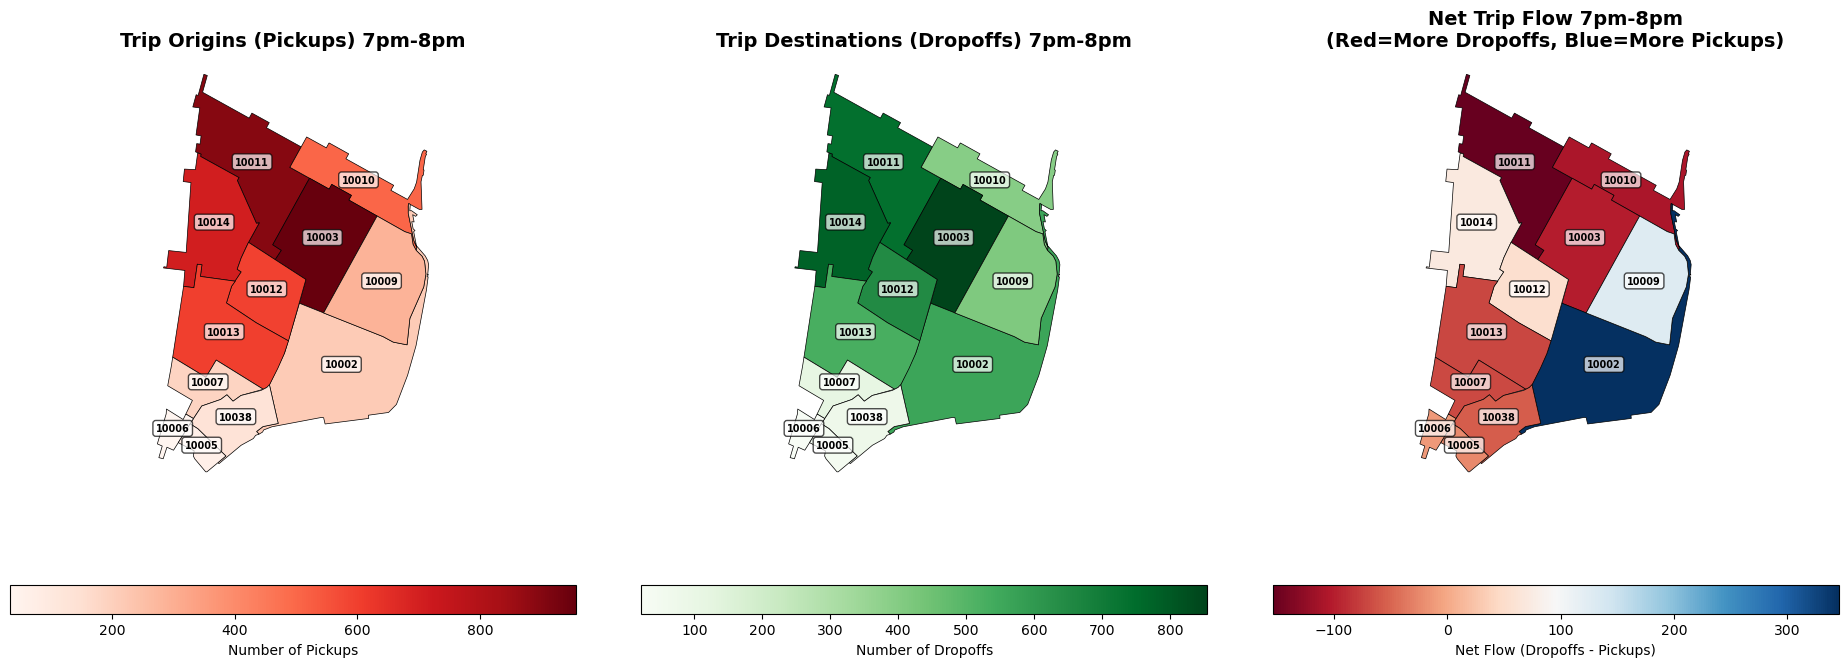


GEOGRAPHIC INSIGHTS (7pm-8pm)

Zip codes with most PICKUPS:
  10003: 956 trips
  10011: 895 trips
  10014: 706 trips
  10013: 600 trips
  10012: 594 trips

Zip codes with most DROPOFFS:
  10003: 855 trips
  10014: 778 trips
  10011: 741 trips
  10012: 648 trips
  10002: 562 trips

Zip codes needing most REBALANCING (net outflow = more pickups):
  10011: -154 net (895 pickups, 741 dropoffs)
  10010: -109 net (505 pickups, 396 dropoffs)
  10003: -101 net (956 pickups, 855 dropoffs)
  10013: -72 net (600 pickups, 528 dropoffs)
  10007: -70 net (186 pickups, 116 dropoffs)


In [25]:
# Geographic visualization of trip flows (7pm-8pm)
manhattan_zones_geo = mh_zones.copy()
zone_to_zip = {idx: zip_code for idx, zip_code in enumerate(MANHATTAN_ZIP_CODES)}

# Calculate total pickups and dropoffs per zone index
origin_counts = trips_7pm_to_8pm.groupby('origin')['demand'].sum()
dest_counts = trips_7pm_to_8pm.groupby('destination')['demand'].sum()

# Create DataFrame with zone index to zip code mapping
origin_df = pd.DataFrame({
    'postalCode': [zone_to_zip[idx] for idx in origin_counts.index],
    'pickups': origin_counts.values
})
dest_df = pd.DataFrame({
    'postalCode': [zone_to_zip[idx] for idx in dest_counts.index],
    'dropoffs': dest_counts.values
})

# Merge with geodataframe
manhattan_zones_geo = manhattan_zones_geo.merge(origin_df, on='postalCode', how='left')
manhattan_zones_geo = manhattan_zones_geo.merge(dest_df, on='postalCode', how='left')
manhattan_zones_geo['pickups'] = manhattan_zones_geo['pickups'].fillna(0)
manhattan_zones_geo['dropoffs'] = manhattan_zones_geo['dropoffs'].fillna(0)
manhattan_zones_geo['net_flow'] = manhattan_zones_geo['dropoffs'] - manhattan_zones_geo['pickups']

# Create geographic visualizations
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Plot 1: Pickup intensity
manhattan_zones_geo.plot(
    column='pickups', 
    ax=axes[0], 
    cmap='Reds', 
    edgecolor='black', 
    linewidth=0.5,
    legend=True,
    legend_kwds={'label': 'Number of Pickups', 'orientation': 'horizontal', 'shrink': 0.8}
)
axes[0].set_title('Trip Origins (Pickups) 7pm-8pm', fontsize=14, fontweight='bold')
axes[0].axis('off')
for idx, row in manhattan_zones_geo.iterrows():
    centroid = row.geometry.centroid
    axes[0].text(centroid.x, centroid.y, str(row['postalCode']), 
                fontsize=7, ha='center', fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Plot 2: Dropoff intensity
manhattan_zones_geo.plot(
    column='dropoffs', 
    ax=axes[1], 
    cmap='Greens', 
    edgecolor='black', 
    linewidth=0.5,
    legend=True,
    legend_kwds={'label': 'Number of Dropoffs', 'orientation': 'horizontal', 'shrink': 0.8}
)
axes[1].set_title('Trip Destinations (Dropoffs) 7pm-8pm', fontsize=14, fontweight='bold')
axes[1].axis('off')
for idx, row in manhattan_zones_geo.iterrows():
    centroid = row.geometry.centroid
    axes[1].text(centroid.x, centroid.y, str(row['postalCode']), 
                fontsize=7, ha='center', fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Plot 3: Net flow (positive = more dropoffs, negative = more pickups)
manhattan_zones_geo.plot(
    column='net_flow', 
    ax=axes[2], 
    cmap='RdBu', 
    edgecolor='black', 
    linewidth=0.5,
    legend=True,
    legend_kwds={'label': 'Net Flow (Dropoffs - Pickups)', 'orientation': 'horizontal', 'shrink': 0.8}
)
axes[2].set_title('Net Trip Flow 7pm-8pm\n(Red=More Dropoffs, Blue=More Pickups)', 
                 fontsize=14, fontweight='bold')
axes[2].axis('off')
for idx, row in manhattan_zones_geo.iterrows():
    centroid = row.geometry.centroid
    axes[2].text(centroid.x, centroid.y, str(row['postalCode']), 
                fontsize=7, ha='center', fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

# Print insights
print("\n" + "="*60)
print("GEOGRAPHIC INSIGHTS (7pm-8pm)")
print("="*60)
print("\nZip codes with most PICKUPS:")
top_pickups = manhattan_zones_geo.nlargest(5, 'pickups')[['postalCode', 'pickups']]
for _, row in top_pickups.iterrows():
    print(f"  {row['postalCode']}: {row['pickups']:.0f} trips")

print("\nZip codes with most DROPOFFS:")
top_dropoffs = manhattan_zones_geo.nlargest(5, 'dropoffs')[['postalCode', 'dropoffs']]
for _, row in top_dropoffs.iterrows():
    print(f"  {row['postalCode']}: {row['dropoffs']:.0f} trips")

print("\nZip codes needing most REBALANCING (net outflow = more pickups):")
need_rebalancing = manhattan_zones_geo.nsmallest(5, 'net_flow')[['postalCode', 'net_flow', 'pickups', 'dropoffs']]
for _, row in need_rebalancing.iterrows():
    print(f"  {row['postalCode']}: {row['net_flow']:.0f} net ({row['pickups']:.0f} pickups, {row['dropoffs']:.0f} dropoffs)")
print("="*60)
